# Overview
This document aims to give an overview of the progress on the project of predicting vapour pressure using MDFPs with code and data

## Baseline
As a first step, an updated conda environment was created used to generate about a single 3D conformer for about 3000 molecules, which were  simulated in water for 5 nanoseconds. The molecules were previously curated by Dr. ShuZe Wang. All conformers are stored in the public database "conformers" and all relevant data is stored in schema cs_mdf_schema.

In [1]:
# We retrieve all conformers that were initially generated (one conformer per molecule using RDKit EmbedMolecule)
#for each property, find the most import features xgBoost

import psycopg2
import json
import pandas as pd
hostname = 'scotland'
dbname = 'cs_mdfps'
username = 'cschiebroek'
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

sql_query = '''
    SELECT cs_mdfps_schema.mdfp_experiment_data.conf_id AS confid,
           public.conformers.molregno,
           cs_mdfps_schema.mdfp_experiment_data.mdfp,
           cs_mdfps_schema.experimental_data.vp_log10pa
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    INNER JOIN cs_mdfps_schema.experimental_data
    ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
    WHERE cs_mdfps_schema.confid_data.confgen_uuid = '906589dd-76fa-4d7b-aa9f-1ee90abe3835'
'''
# Execute the SQL query
cur.execute(sql_query)
df_mdfps = pd.DataFrame(cur.fetchall(), columns=['confid', 'molregno', 'mdfp', 'vp'])
df_mdfps['mdfp'] = df_mdfps['mdfp'].apply(lambda x: json.loads(x['mdfp']))
print('Datapoints first experiment: ', len(df_mdfps))
df_mdfps.head()

Datapoints first experiment:  3019


,confid,molregno,mdfp,vp
0,2388,2390,"[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24.3637634540...",2.325205
1,2394,2396,"[7, 4, 0, 1, 0, 0, 0, 0, 0, 0, -4.742220929815...",2.092080
2,2400,2402,"[10, 2, 2, 0, 0, 0, 0, 0, 0, 0, -13.4724999801...",0.000000
3,2406,2408,"[14, 3, 4, 3, 0, 0, 0, 0, 0, 0, -411.884680244...",-3.822020
4,2411,2413,"[15, 2, 0, 1, 0, 0, 0, 0, 2, 0, -36.3113182099...",-1.772345


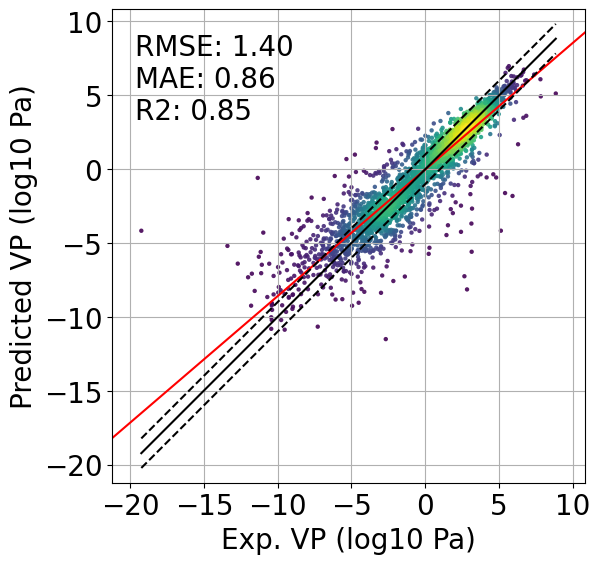

In [2]:
from utils_carl import train_pred_xgboost,density_plot,getStatValues
from functools import reduce
import warnings

# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
params = { #hyperparameters optimized by ShuZe Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
output = train_pred_xgboost(df_mdfps,params,splits=5) #we do 5-fold cross-validation
real_one_to_one, prediction_one_to_one = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
density_plot(real_one_to_one,prediction_one_to_one,print_stats=False)

We get decent predictions, in line with results obtained by ShuZe

## Using multiple starting conformers

We perform a few tests assing:
1. The performance of model trained on one conformer on different conformers from the same molecule
2. Does data augmentation with multiple starting conformers per mol improve the performance

### Predictive ability towards new conformers

In [3]:
#train model on one conformer of all molecules
import xgboost as xgb
import numpy as np
train_x = np.array(df_mdfps['mdfp'].tolist())
train_y = np.array(df_mdfps['vp'].tolist())
dtrain = xgb.DMatrix(train_x, label=train_y)
model_trained_oneconf_per_mol = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    verbose_eval=False
)

In [4]:
#Fetch all conformers that were generated in the second round (using RDKit EmbedMultipleConfs, and picked diverse using MaxMin algorithm)
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = '''
    SELECT cs_mdfps_schema.mdfp_experiment_data.conf_id AS confid,
           public.conformers.molregno,
           cs_mdfps_schema.mdfp_experiment_data.mdfp,
           cs_mdfps_schema.experimental_data.vp_log10pa
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    INNER JOIN cs_mdfps_schema.experimental_data
    ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
    WHERE cs_mdfps_schema.confid_data.confgen_uuid = '11093a30-b6d0-4e3f-a22b-8dcad60d6a11'
'''
# Execute the SQL query
cur.execute(sql_query)
df_new_confs = pd.DataFrame(cur.fetchall(), columns=['confid', 'molregno', 'mdfp', 'vp'])
df_new_confs['mdfp'] = df_new_confs['mdfp'].apply(lambda x: json.loads(x['mdfp']))

In [5]:
from utils_carl import train_pred_xgboost,density_plot,getStatValues
test_x = np.array(df_new_confs['mdfp'].tolist())
real_one_to_many_confs = np.array(df_new_confs['vp'].tolist())
dtest = xgb.DMatrix(test_x, label=real_one_to_many_confs)
preds_one_to_many_same_mol = model_trained_oneconf_per_mol.predict(dtest)

Because we use a different random seed for creating these new conformers, some conformers are actually structually the same as the 'old' conformers, but are registered as new as they have different coordinates. While this is technically a mistake and a waste or resources, we can use this as an oppurtunity to look at the impact at the simulation level of two same starting conformers

In [6]:
import pickle   
with open('duplicate_confids.pkl', 'rb') as f:
    duplicate_confids = pickle.load(f)
df_new_confs_no_dups = df_new_confs[~df_new_confs['confid'].isin(duplicate_confids)]
print(len(df_new_confs_no_dups), len(df_new_confs))
test_x = np.array(df_new_confs_no_dups['mdfp'].tolist())
test_y_no_dups = np.array(df_new_confs_no_dups['vp'].tolist())
dtest = xgb.DMatrix(test_x, label=test_y_no_dups)
preds_one_to_many_same_mol_no_dups = model_trained_oneconf_per_mol.predict(dtest)
df_new_confs_only_dups = df_new_confs[df_new_confs['confid'].isin(duplicate_confids)]
print(len(df_new_confs_only_dups), len(df_new_confs))
test_x = np.array(df_new_confs_only_dups['mdfp'].tolist())
test_y_dups = np.array(df_new_confs_only_dups['vp'].tolist())
dtest = xgb.DMatrix(test_x, label=test_y_dups)
preds_dups = model_trained_oneconf_per_mol.predict(dtest)


10725 11197
472 11197


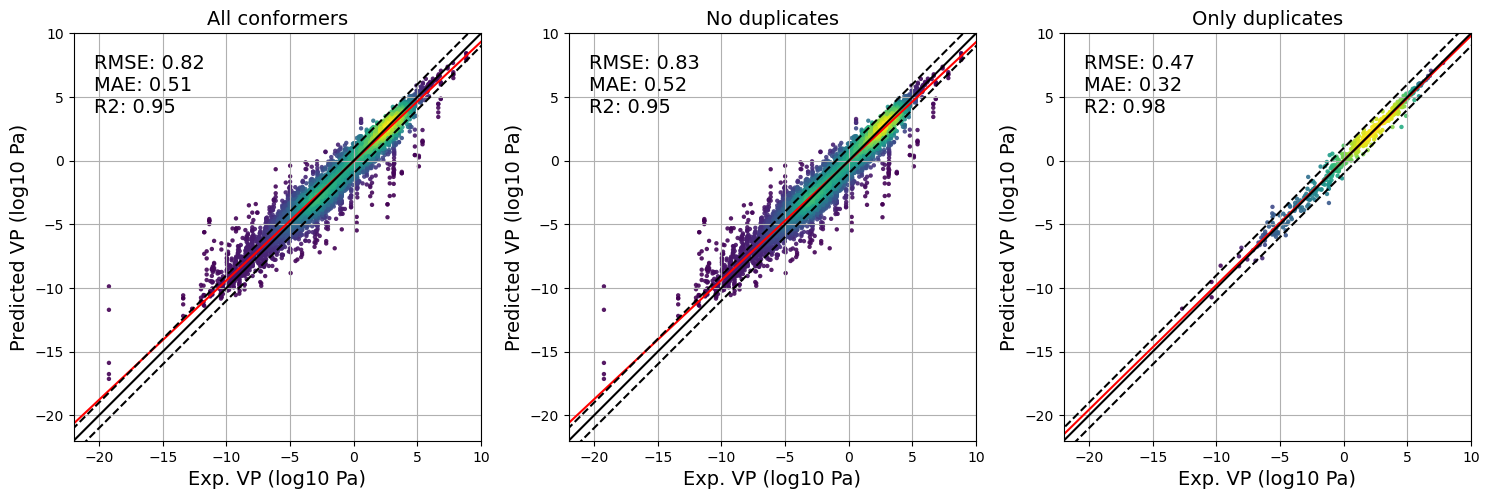

In [7]:
from utils_carl import density_plot_multiple
reals_lol = [real_one_to_many_confs, test_y_no_dups, test_y_dups]
preds_lol = [preds_one_to_many_same_mol, preds_one_to_many_same_mol_no_dups, preds_dups]
density_plot_multiple(reals_lol, preds_lol,titles = ['All conformers', 'No duplicates', 'Only duplicates'], bounds = [-22,10],print_stats=False)

In [8]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = '''
    SELECT cs_mdfps_schema.mdfp_experiment_data.conf_id AS confid,
           public.conformers.molregno,
           cs_mdfps_schema.mdfp_experiment_data.mdfp,
           cs_mdfps_schema.experimental_data.vp_log10pa
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    INNER JOIN cs_mdfps_schema.experimental_data
    ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
'''
# Execute the SQL query
cur.execute(sql_query)

# Fetch the results if needed
results = cur.fetchall()
print(f'{len(results)} results fetched')
data_full = pd.DataFrame(results, columns=['confid', 'molregno', 'mdfp', 'vp'])
#mdfp; load the dict, get only the value for key 'mdfp' and json.loads it
data_full['mdfp'] = data_full['mdfp'].apply(lambda x: json.loads(x['mdfp']))
data_full.head()

14216 results fetched


,confid,molregno,mdfp,vp
0,1150,7,"[9, 5, 0, 0, 0, 0, 0, 0, 0, 0, 7.3614322526332...",2.698933
1,1151,8,"[13, 1, 0, 2, 0, 0, 0, 0, 0, 0, -97.7987770071...",-3.053323
2,2388,2390,"[10, 1, 0, 0, 0, 0, 0, 0, 0, 0, -24.3637634540...",2.325205
3,2400,2402,"[10, 2, 2, 0, 0, 0, 0, 0, 0, 0, -13.4724999801...",0.000000
4,2415,2417,"[15, 4, 1, 1, 0, 0, 1, 2, 0, 0, -174.933858069...",-1.700000


In [9]:
#get all molregnos from data_full that appear 5 or more times
molregnos = data_full['molregno'].value_counts()
molregnos = molregnos[molregnos == 6].index.tolist()
print(f'{len(molregnos)} molregnos with 6 conformers')
df_6_confs = data_full[data_full['molregno'].isin(molregnos)].copy()
#make another df with the rest of the data
#split data in six folds so that each fold has at least one conformer of each molregno
df_6_confs['fold'] = np.nan
for molregno in molregnos:
    #assign a fold to each conformer of this molregno
    df_6_confs.loc[df_6_confs['molregno'] == molregno, 'fold'] = np.arange(6)
df_6_confs['fold'] = df_6_confs['fold'].astype(int)
#check if each fold has at least one conformer of each molregno
for molregno in molregnos:
    if len(df_6_confs[df_6_confs['molregno'] == molregno]['fold'].unique()) != 6:
        print(f'molregno {molregno} not in each fold')
        break
train_base = data_full[~data_full['molregno'].isin(molregnos)].copy()
#check overlap between train_base and df_6_confs for confids 
train_base_confids = train_base['confid'].tolist()
df_6_confs_confids = df_6_confs['confid'].tolist()
overlap = set(train_base_confids).intersection(df_6_confs_confids)
print(f'Overlap: {len(overlap)}')
output = ([],[],[],[])
for fold in range(6):
    #get test data for this fold
    test = df_6_confs[df_6_confs['fold'] == fold].copy()
    #the rest to train
    train = df_6_confs[df_6_confs['fold'] != fold].copy()
    #add train_base to train
    train = pd.concat([train, train_base], ignore_index=True)
    
    #get the mdfps and vps of the conformers for this fold
    test_x = np.array(test['mdfp'].tolist())
    test_y = np.array(test['vp'].tolist())
    train_x = np.array(train['mdfp'].tolist())
    train_y = np.array(train['vp'].tolist())

    #check if no overlap of confids between test and train
    if len(set(test['confid']).intersection(set(train['confid']))) != 0:
        print('overlap between test and train: ', len(set(test['confid']).intersection(set(train['confid']))))
        break

    #get molregnos test
    molregnos_test = test['molregno'].tolist()
    #get confids test
    confids_test = test['confid'].tolist()
   

    # Create DMatrix for training and testing
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dtest = xgb.DMatrix(test_x, label=test_y)
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10,
        verbose_eval=False

    )
    pp = model.predict(dtest)

    output[0].append(test_y)
    output[1].append(pp)
    output[2].append(molregnos_test)
    output[3].append(confids_test)


1723 molregnos with 6 conformers


Overlap: 0


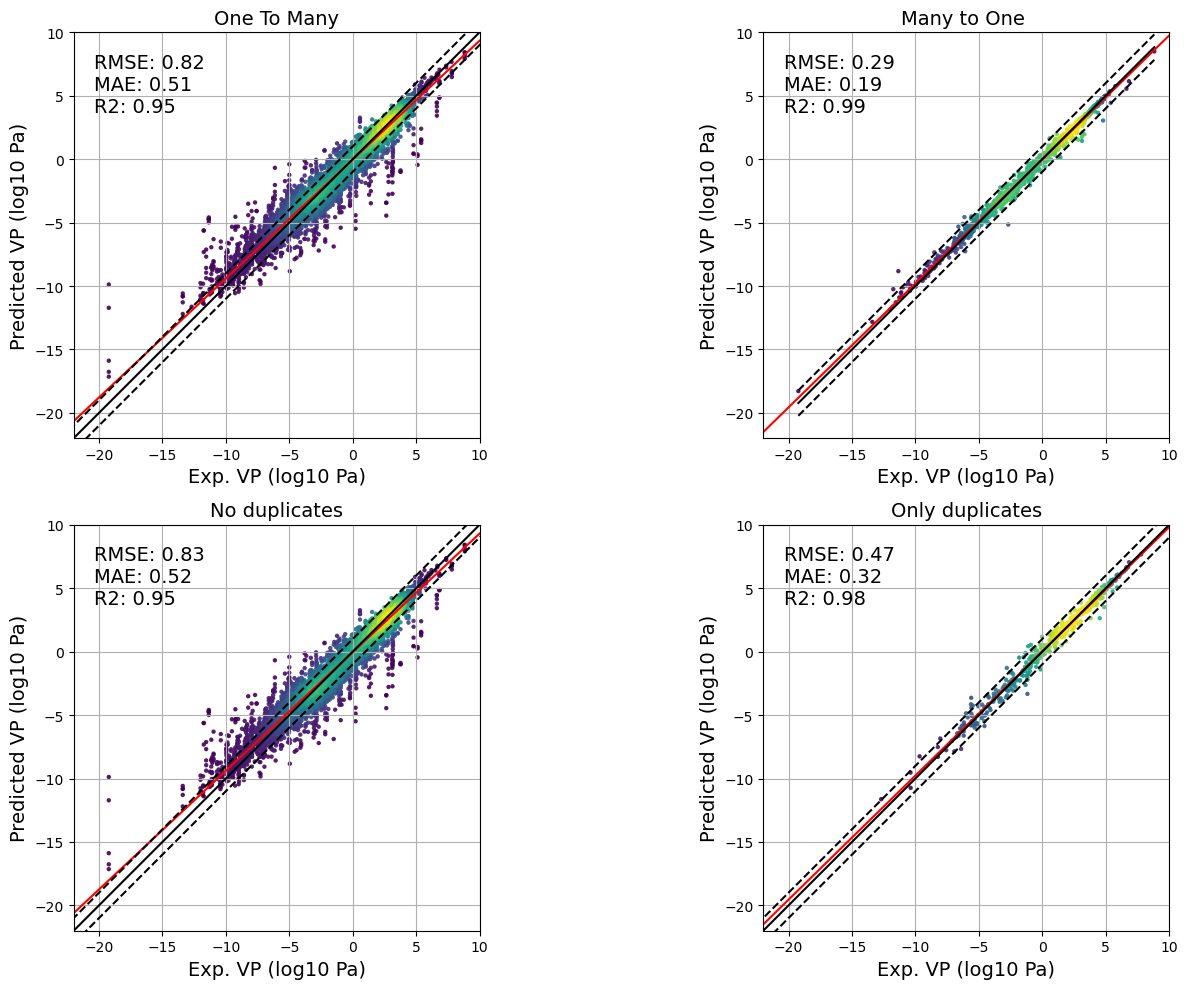

In [10]:
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])
df_preds = pd.DataFrame({'vp': vps, 'pred': preds, 'confid': confids, 'molregno': molregnos})
df_preds = df_preds.groupby('molregno').mean()
prediction_train_5_confs_pred_6 = df_preds['pred'].tolist()
real_train_5_confs_pred_6 = df_preds['vp'].tolist()

reals_lol = [real_one_to_many_confs, real_train_5_confs_pred_6,test_y_no_dups, test_y_dups]
preds_lol = [preds_one_to_many_same_mol, prediction_train_5_confs_pred_6,preds_one_to_many_same_mol_no_dups, preds_dups]
density_plot_multiple(reals_lol, preds_lol,titles = ['One To Many','Many to One ','No duplicates', 'Only duplicates'], bounds = [-22,10],print_stats=False)


So predicting the vapour pressure for a different starting conformer of the same molecule works quite well when looking at the correlation, but there is still quite a big RMSE.

### Data augmentation

In [12]:
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

# Define the SQL query to perform the joins with schema qualification
sql_query = '''
    SELECT cs_mdfps_schema.mdfp_experiment_data.conf_id AS confid,
           public.conformers.molregno,
           cs_mdfps_schema.mdfp_experiment_data.mdfp,
           cs_mdfps_schema.experimental_data.vp_log10pa
    FROM cs_mdfps_schema.mdfp_experiment_data
    INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
    INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
    INNER JOIN cs_mdfps_schema.experimental_data
    ON public.conformers.molregno = cs_mdfps_schema.experimental_data.molregno
'''
# Execute the SQL query
cur.execute(sql_query)
data_full = pd.DataFrame(cur.fetchall(), columns=['confid', 'molregno', 'mdfp', 'vp'])
data_full['mdfp'] = data_full['mdfp'].apply(lambda x: json.loads(x['mdfp']))

In [13]:
params = { #new hyperparameters as found by 002_HP_opt.py
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
}
output = train_pred_xgboost(data_full,params,return_confids=True)
real, prediction = (reduce(lambda a,b : list(a)+list(b) , output[0]), reduce(lambda a,b : list(a)+list(b), output[1]))
#average over conformers
vps = reduce(lambda a,b : list(a)+list(b) , output[0])
preds = reduce(lambda a,b : list(a)+list(b), output[1])
molregnos = reduce(lambda a,b : list(a)+list(b), output[2])
confids = reduce(lambda a,b : list(a)+list(b), output[3])
df_preds = pd.DataFrame({'vp': vps, 'pred': preds, 'confid': confids, 'molregno': molregnos})
df_preds = df_preds.groupby('molregno').mean()
prediction_many_to_many = df_preds['pred'].tolist()
real_many_to_many = df_preds['vp'].tolist()
# density_plot(real,prediction)
# slope_conf_augmented_averaged, intercept_conf_augmented_averaged, r2_conf_augmented_averaged, rmse_conf_augmented_averaged, mae_conf_augmented_averaged = getStatValues(prediction, real)

Data augmentation resulted in a decrease in error metrics RMSE and MAE but not much in correlation

now look at the four scenarios for new mols:
1. many to many (split by molregno on data_full)
2. many to one (train on df_new_confs, predict df_mdfps. Look at with and without removing duplictes)
3. one to many (train on df_mdfps, pred df_new_confs)
4. one to one (split by molregno on df_mdfps)



In [14]:
#fairest if we compare the same number of conformers. So maybe first split data_full into five folds. For each fold, check how many unique molregnos and how many conf_ids
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5)

# Create an empty list to store the indices of each fold
fold_indices = []

# Group the data by 'molregno'
groups = data_full['molregno']
params_one = { #hyperparameters optimized by ShuZe Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}
params_many = { #new hyperparameters as found by 002_HP_opt.py
    'max_depth':9,
    'min_child_weight': 4,
    'eta':.05,
    'subsample': 1,
    'colsample_bytree': 0.5,
}
# Iterate over each fold
outputs = ([],[],[],[],[],[],[],[],[],[],[])

for train_idx, test_idx in gkf.split(data_full, groups=groups):
    #first we split the whole data by molregno
    train_all = data_full.iloc[train_idx]
    test_all = data_full.iloc[test_idx]

    #then we make a seperate set with only one conformer per molregno
    molregnos_train = train_all['molregno'].unique().tolist()
    confids_train = []
    for molregno in molregnos_train:
        confids = train_all[train_all['molregno'] == molregno]['confid'].tolist()
        confids_train.append(np.random.choice(confids, 1)[0])
    train_one_to_one = train_all[train_all['confid'].isin(confids_train)].copy()

    molregnos_test_one = test_all['molregno'].unique().tolist()
    molregnos_test_many = test_all['molregno'].tolist()
    confids_test_all = test_all['confid'].tolist()
    confids_test_one = []
    confids_test_many = test_all['confid'].tolist()
    for molregno in molregnos_test_one:
        confids = test_all[test_all['molregno'] == molregno]['confid'].tolist()       
        confids_test_one.append(np.random.choice(confids, 1)[0])
    test_one_to_one = test_all[test_all['confid'].isin(confids_test_one)].copy()

    train_x_one = np.array(train_one_to_one['mdfp'].tolist())
    train_y_one = np.array(train_one_to_one['vp'].tolist())
    dtrain_one = xgb.DMatrix(train_x_one, label=train_y_one)
    
    test_x_one = np.array(test_one_to_one['mdfp'].tolist())
    test_y_one = np.array(test_one_to_one['vp'].tolist())
    dtest_one = xgb.DMatrix(test_x_one, label=test_y_one)

    train_x_many = np.array(train_all['mdfp'].tolist())
    train_y_many = np.array(train_all['vp'].tolist())
    dtrain_many = xgb.DMatrix(train_x_many, label=train_y_many)

    test_x_many = np.array(test_all['mdfp'].tolist())
    test_y_many = np.array(test_all['vp'].tolist())
    dtest_many = xgb.DMatrix(test_x_many, label=test_y_many)

    #now for all four, train models and predict
    model_one = xgb.train(
        params_one,
        dtrain_one,
        num_boost_round=999,
        verbose_eval=False
    )
    model_many = xgb.train(
        params_many,
        dtrain_many,
        num_boost_round=999,
        verbose_eval=False
    )
    preds_one_to_one = model_one.predict(dtest_one)
    preds_many_to_many = model_many.predict(dtest_many)

    preds_one_to_many = model_one.predict(dtest_many)
    preds_many_to_one = model_many.predict(dtest_one)

    outputs[0].append(preds_one_to_one)
    outputs[1].append(preds_many_to_many)
    outputs[2].append(preds_one_to_many)
    outputs[3].append(preds_many_to_one)

    outputs[4].append(test_y_one)
    outputs[5].append(test_y_many)

    outputs[6].append(molregnos_test_one)
    outputs[7].append(molregnos_test_many)

    outputs[8].append(confids_test_one)
    outputs[9].append(confids_test_many)

    #check output lengths: all 'many' should be equal and all 'one' should be equal
    if len(preds_one_to_one) != len(preds_many_to_one) != len(test_y_one) != len(molregnos_test_one) != len(confids_test_one):
        print('lengths not equal')
        print(len(preds_one_to_one), len(preds_many_to_one), len(test_y_one), len(molregnos_test_one), len(confids_test_one))
        break
    if len(preds_many_to_many) != len(preds_one_to_many) != len(test_y_many) != len(molregnos_test_many) != len(confids_test_many):
        print('lengths not equal')
        print(len(preds_many_to_many), len(preds_one_to_many), len(test_y_many), len(molregnos_test_many), len(confids_test_many))
        break


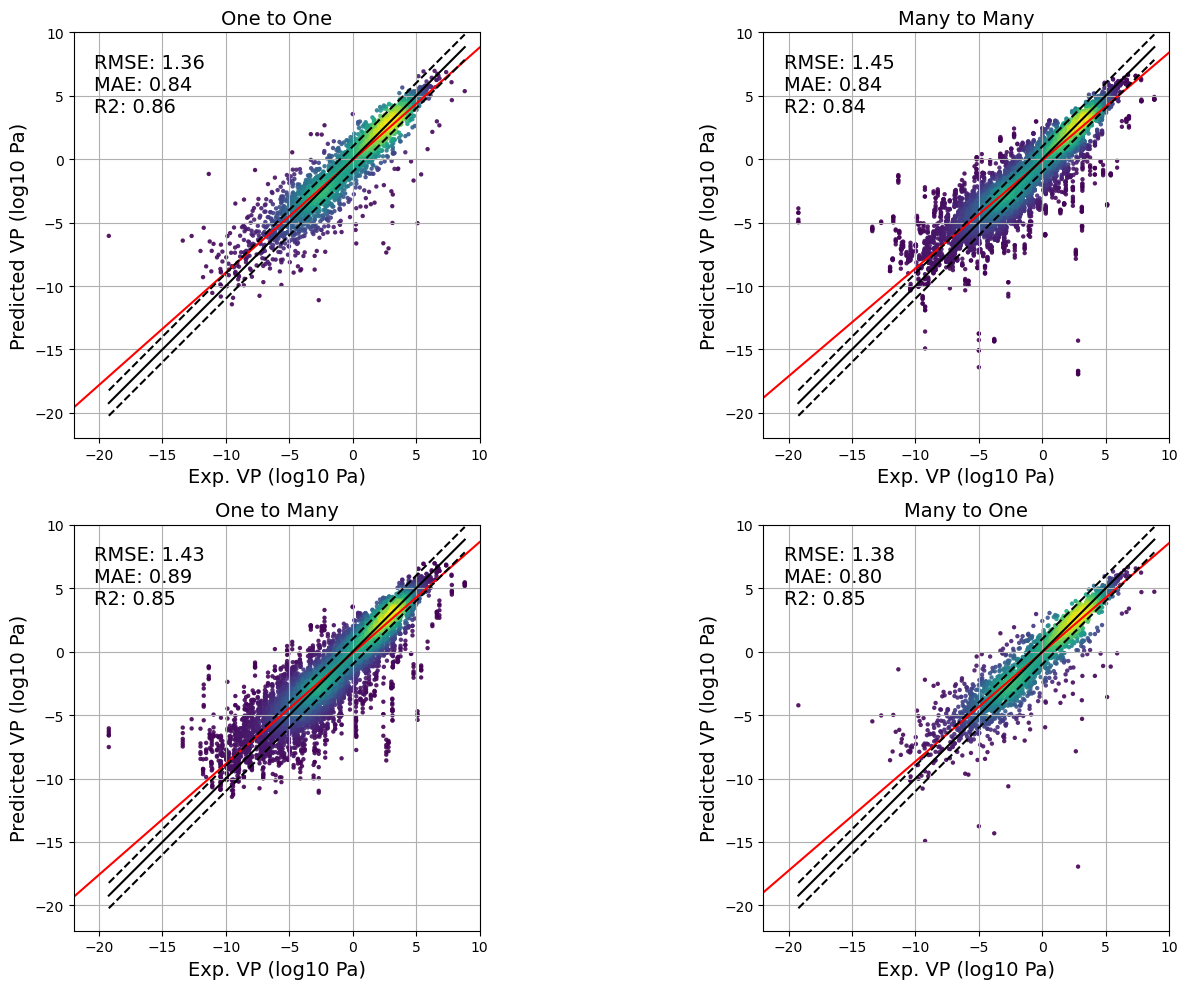

In [15]:
preds_one_to_one = reduce(lambda a,b : list(a)+list(b), outputs[0])
preds_many_to_many = reduce(lambda a,b : list(a)+list(b), outputs[1])
preds_one_to_many = reduce(lambda a,b : list(a)+list(b), outputs[2])
preds_many_to_one = reduce(lambda a,b : list(a)+list(b), outputs[3])
test_y_one = reduce(lambda a,b : list(a)+list(b), outputs[4])
test_y_many = reduce(lambda a,b : list(a)+list(b), outputs[5])

pred_lol = [preds_one_to_one, preds_many_to_many, preds_one_to_many, preds_many_to_one]
real_lol = [test_y_one, test_y_many, test_y_many, test_y_one]
titles = ['One to One', 'Many to Many', 'One to Many', 'Many to One']
density_plot_multiple(real_lol, pred_lol, titles=titles, bounds = [-22,10], print_stats=False)

preds_one_to_one: 3019
preds_many_to_many: 14216
preds_one_to_many: 14216
preds_many_to_one: 3019
test_y_one: 3019
test_y_many: 14216
molregnos_one: 3019
molregnos_many: 14216
confids_test_one: 3019
confids_test_all: 14216


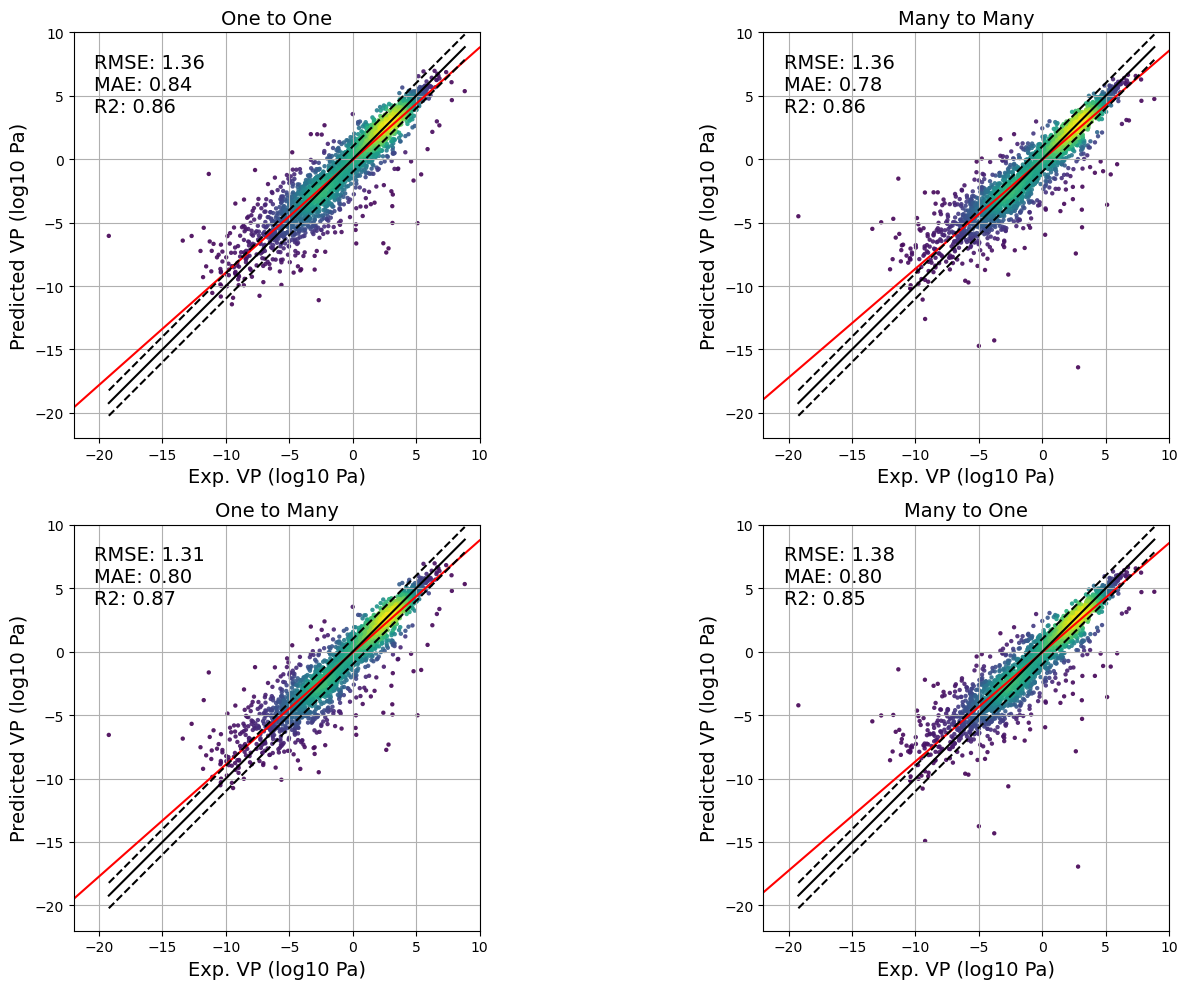

In [29]:
#repeat with averging for the many. 
preds_one_to_one = reduce(lambda a,b : list(a)+list(b), outputs[0])
preds_many_to_many = reduce(lambda a,b : list(a)+list(b), outputs[1])
preds_one_to_many = reduce(lambda a,b : list(a)+list(b), outputs[2])
preds_many_to_one = reduce(lambda a,b : list(a)+list(b), outputs[3])
test_y_one = reduce(lambda a,b : list(a)+list(b), outputs[4])
test_y_many = reduce(lambda a,b : list(a)+list(b), outputs[5])
molregnos_one = reduce(lambda a,b : list(a)+list(b), outputs[6])
molregnos_many = reduce(lambda a,b : list(a)+list(b), outputs[7])
confids_test_one = reduce(lambda a,b : list(a)+list(b), outputs[8])
confids_test_all = reduce(lambda a,b : list(a)+list(b), outputs[9])
#check; print lenght of all with name of list in print statement
print(f'preds_one_to_one: {len(preds_one_to_one)}')
print(f'preds_many_to_many: {len(preds_many_to_many)}')
print(f'preds_one_to_many: {len(preds_one_to_many)}')
print(f'preds_many_to_one: {len(preds_many_to_one)}')
print(f'test_y_one: {len(test_y_one)}')
print(f'test_y_many: {len(test_y_many)}')
print(f'molregnos_one: {len(molregnos_one)}')
print(f'molregnos_many: {len(molregnos_many)}')
print(f'confids_test_one: {len(confids_test_one)}')
print(f'confids_test_all: {len(confids_test_all)}')

df_preds_one_to_one = pd.DataFrame({'vp': test_y_one, 'pred': preds_one_to_one, 'confid': confids_test_one, 'molregno': molregnos_one})
df_preds_one_to_one = df_preds_one_to_one.groupby('molregno').mean()
preds_one_to_one_mean = df_preds_one_to_one['pred'].tolist()
test_y_one_mean = df_preds_one_to_one['vp'].tolist()

df_preds_many_to_many = pd.DataFrame({'vp': test_y_many, 'pred': preds_many_to_many, 'confid': confids_test_all, 'molregno': molregnos_many})
df_preds_many_to_many = df_preds_many_to_many.groupby('molregno').mean()
preds_many_to_many_mean = df_preds_many_to_many['pred'].tolist()
test_y_many_mean = df_preds_many_to_many['vp'].tolist()

df_preds_one_to_many = pd.DataFrame({'vp': test_y_many, 'pred': preds_one_to_many, 'confid': confids_test_all, 'molregno': molregnos_many})
df_preds_one_to_many = df_preds_one_to_many.groupby('molregno').mean()
preds_one_to_many_mean = df_preds_one_to_many['pred'].tolist()
test_y_many_mean = df_preds_one_to_many['vp'].tolist()

df_preds_many_to_one = pd.DataFrame({'vp': test_y_one, 'pred': preds_many_to_one, 'confid': confids_test_one, 'molregno': molregnos_one})
df_preds_many_to_one = df_preds_many_to_one.groupby('molregno').mean()
preds_many_to_one_mean = df_preds_many_to_one['pred'].tolist()
test_y_one_mean = df_preds_many_to_one['vp'].tolist()

pred_lol = [preds_one_to_one_mean, preds_many_to_many_mean, preds_one_to_many_mean, preds_many_to_one_mean]
real_lol = [test_y_one_mean, test_y_many_mean, test_y_many_mean, test_y_one_mean]
titles = ['One to One', 'Many to Many', 'One to Many', 'Many to One']
density_plot_multiple(real_lol, pred_lol, titles=titles, bounds = [-22,10], print_stats=False)

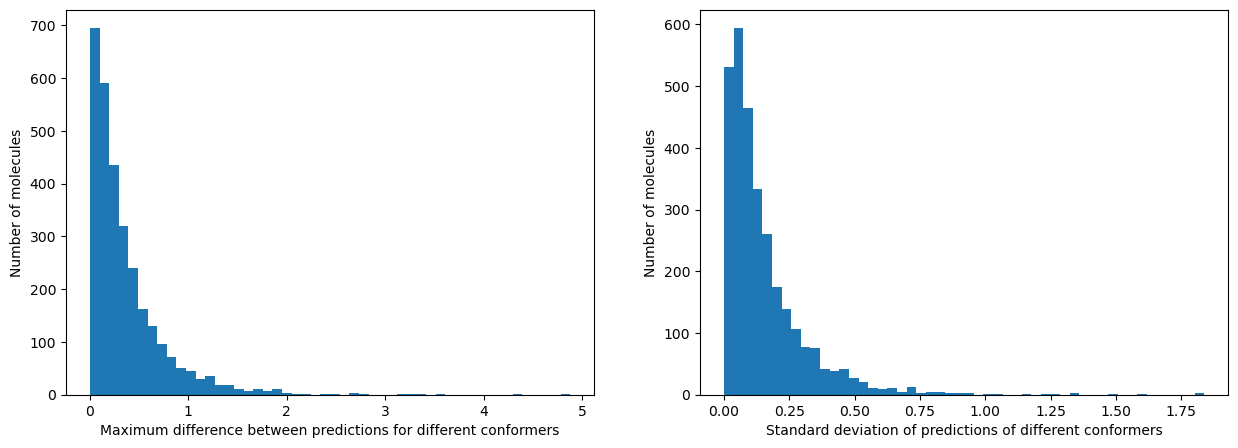

In [30]:
df_preds_many_to_many = pd.DataFrame({'vp': test_y_many, 'prediction': preds_many_to_many, 'confid': confids_test_all, 'molregno': molregnos_many})
max_diffs = df_preds_many_to_many.groupby('molregno').agg({'prediction': ['max','min']})
max_diffs['diff'] = max_diffs['prediction']['max'] - max_diffs['prediction']['min']
max_diffs_list = max_diffs['diff'].tolist()
stds = df_preds_many_to_many.groupby('molregno').agg({'prediction': ['std']})
max_diffs_list = [diff for diff in max_diffs_list if diff != 0]
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(max_diffs_list, bins=50)
axs[0].set_xlabel('Maximum difference between predictions for different conformers')
axs[0].set_ylabel('Number of molecules')
axs[1].hist(stds['prediction']['std'].tolist(), bins=50)
axs[1].set_xlabel('Standard deviation of predictions of different conformers')
axs[1].set_ylabel('Number of molecules')
plt.show()


In [37]:
# df_preds_many_to_many = df_preds_many_to_many.drop(columns=['confid'])
df_preds_many_to_many['abs_error'] = abs(df_preds_many_to_many['vp'] - df_preds_many_to_many['prediction'])
df_preds_many_to_many
#get the molblocks for these molregnos
cn = psycopg2.connect(host=hostname, dbname=dbname, user=username)
cur = cn.cursor()

sql_query = '''
SELECT
    cs_mdfps_schema.mdfp_experiment_data.conf_id AS conf_id,
    public.conformers.molregno,
    public.conformers.molblock
FROM cs_mdfps_schema.mdfp_experiment_data
INNER JOIN public.conformers
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = public.conformers.conf_id
INNER JOIN cs_mdfps_schema.confid_data
    ON cs_mdfps_schema.mdfp_experiment_data.conf_id = cs_mdfps_schema.confid_data.conf_id
WHERE cs_mdfps_schema.confid_data.confgen_uuid = '906589dd-76fa-4d7b-aa9f-1ee90abe3835'

'''
cur.execute(sql_query)
results = cur.fetchall()
#make dict from molregno to molblock
results[0] 


(2388,
 2390,
 '[H]C([H])=C1C([H])=C([H])[C@]([H])(C([H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])C1([H])[H]\n     RDKit          3D\n\n  0  0  0  0  0  0  0  0  0  0999 V3000\nM  V30 BEGIN CTAB\nM  V30 COUNTS 10 10 0 0 0\nM  V30 BEGIN ATOM\nM  V30 1 C 3.504903 0.510746 0.342615 0\nM  V30 2 C 2.305884 -0.017947 0.313519 0\nM  V30 3 C 1.386762 0.217584 1.405386 0\nM  V30 4 C 0.093030 0.307013 1.115199 0\nM  V30 5 C -0.280772 0.156627 -0.302815 0 CFG=2\nM  V30 6 C -1.757313 0.178518 -0.497845 0\nM  V30 7 C -2.426833 -0.952773 0.272219 0\nM  V30 8 C -2.284437 1.506201 -0.002609 0\nM  V30 9 C 0.407432 -1.019146 -0.953583 0\nM  V30 10 C 1.882801 -0.862709 -0.821664 0\nM  V30 END ATOM\nM  V30 BEGIN BOND\nM  V30 1 2 1 2\nM  V30 2 1 2 3\nM  V30 3 2 3 4\nM  V30 4 1 4 5\nM  V30 5 1 5 6 CFG=1\nM  V30 6 1 6 7\nM  V30 7 1 6 8\nM  V30 8 1 5 9\nM  V30 9 1 9 10\nM  V30 10 1 10 2\nM  V30 END BOND\nM  V30 END CTAB\nM  END\n')

In [38]:
from rdkit import Chem
from rdkit.Chem import Descriptors
molregno_to_molblock = {}
for result in results:
    molregno_to_molblock[result[1]] = result[2]
    
molregnos = df_preds_many_to_many['molregno'].tolist()
molblocks = [molregno_to_molblock[molregno] for molregno in molregnos]
mols = [Chem.MolFromMolBlock(molblock) for molblock in molblocks]
n_rotatable_bonds = [Descriptors.NumRotatableBonds(mol) for mol in mols]
df_preds_many_to_many['n_rotatable_bonds'] = n_rotatable_bonds
df_preds_many_to_many

[17:12:28] Warning: molecule is tagged as 3D, but all Z coords are zero
[17:12:29] Warning: molecule is tagged as 3D, but all Z coords are zero


,vp,prediction,confid,molregno,abs_error,n_rotatable_bonds
0,3.662114,3.194558,1156,13,0.467557,2
1,-4.999998,-5.187781,1160,17,0.187783,6
2,4.626578,4.339359,1179,36,0.287219,1
3,4.722119,3.367540,1188,45,1.354580,2
4,3.830473,3.578526,1187,44,0.251946,2
...,...,...,...,...,...,...
14211,-5.408231,-4.998048,15579,342,0.410182,6
14212,1.741587,1.244807,15523,3918,0.496780,0
14213,-5.408231,-5.035302,15582,342,0.372929,6
14214,1.682409,2.748729,15630,3859,1.066320,1


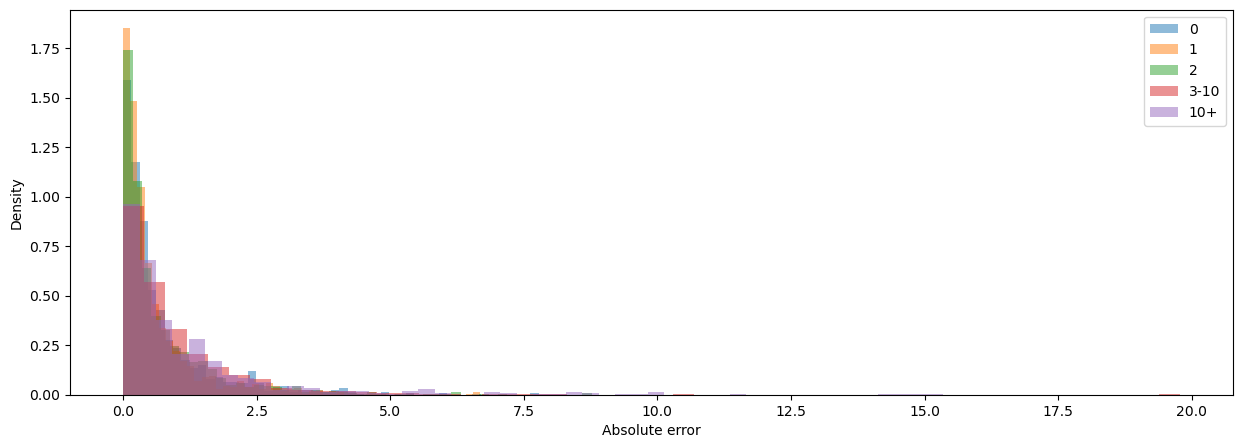

In [39]:
#for each number of rotatable bonds, do a histogram of the absolute errors
#overlay all, make sure everyting is on the same scale
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
#merge together all n_rotatable_bonds > 10
for n in range(4):
    if n < 3:
        df_temp = df_preds_many_to_many[df_preds_many_to_many['n_rotatable_bonds'] == n]
        axs.hist(df_temp['abs_error'], bins=50, label=n, alpha=0.5, density=True)
    else:
        #get df with n_rotatable_bonds > 3 but smaller then 10
        df_temp = df_preds_many_to_many[df_preds_many_to_many['n_rotatable_bonds'] > 3]
        df_temp = df_temp[df_temp['n_rotatable_bonds'] < 10]
        axs.hist(df_temp['abs_error'], bins=50, label="3-10", alpha=0.5, density=True)
        #and bigger then 10
        df_temp = df_preds_many_to_many[df_preds_many_to_many['n_rotatable_bonds'] >= 10]
        axs.hist(df_temp['abs_error'], bins=50, label="10+", alpha=0.5, density=True)

axs.legend()
axs.set_xlabel('Absolute error')
axs.set_ylabel('Density')
plt.show()


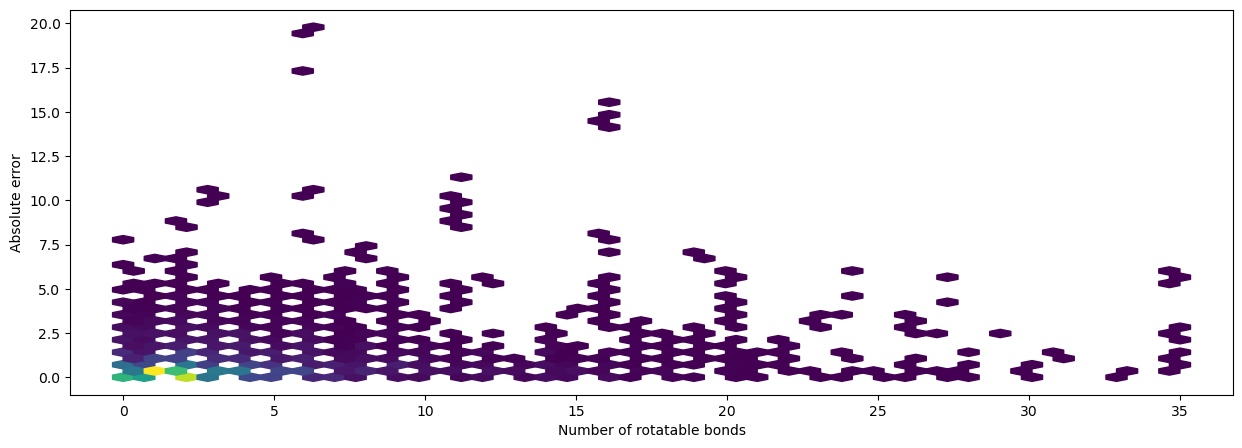

In [40]:
#do hexbin plot of n_rotatable_bonds vs abs_error
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.hexbin(df_preds_many_to_many['n_rotatable_bonds'], df_preds_many_to_many['abs_error'], gridsize=50,mincnt=1)
axs.set_xlabel('Number of rotatable bonds')
axs.set_ylabel('Absolute error')
plt.show()

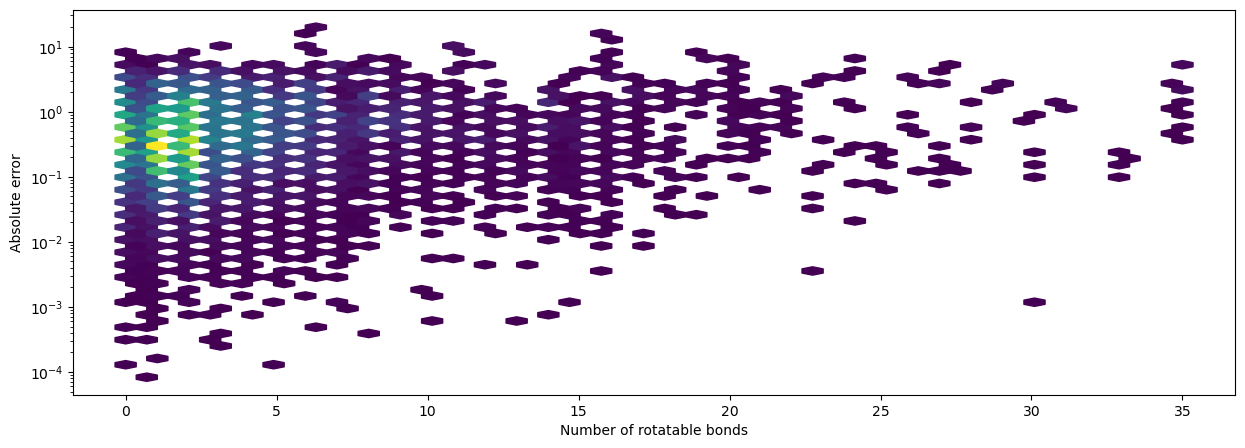

In [41]:
#maybe error on logscale?
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.hexbin(df_preds_many_to_many['n_rotatable_bonds'], df_preds_many_to_many['abs_error'], gridsize=50,mincnt=1, yscale='log')
axs.set_xlabel('Number of rotatable bonds')
axs.set_ylabel('Absolute error')
plt.show()


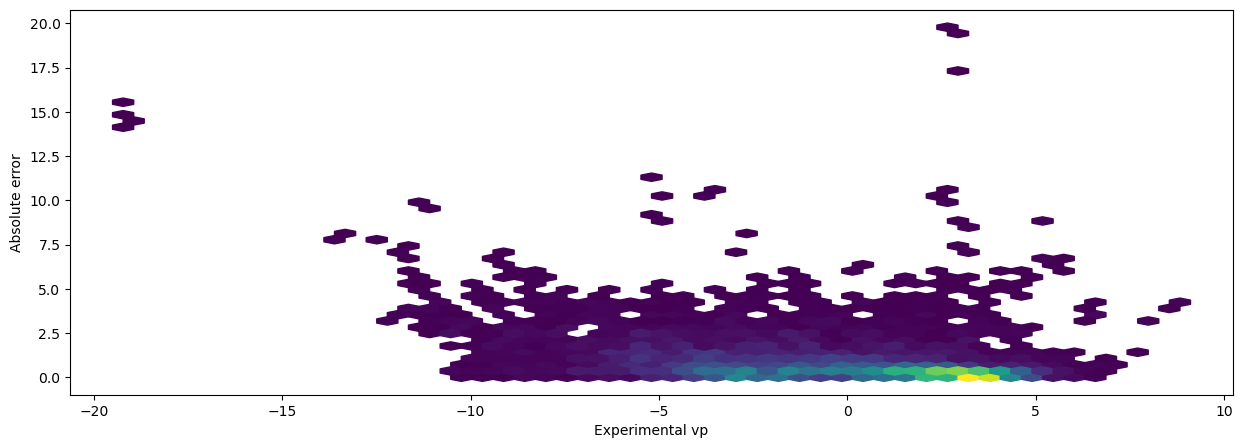

In [43]:
#plot prediction error as function of experimental vp in density plot
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.hexbin(df_preds_many_to_many['vp'], df_preds_many_to_many['abs_error'], gridsize=50,mincnt=1)
axs.set_xlabel('Experimental vp')
axs.set_ylabel('Absolute error')
plt.show()



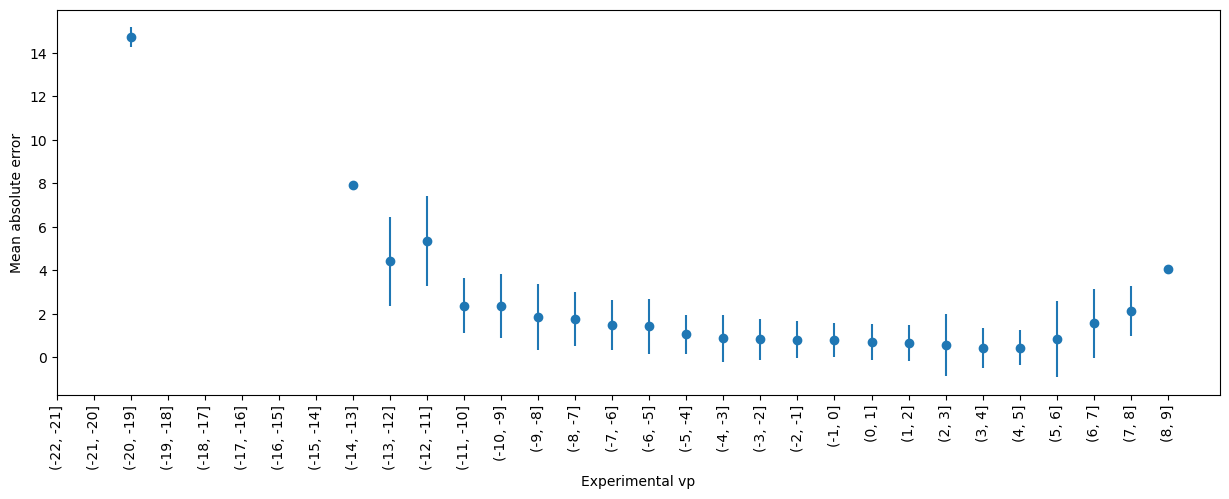

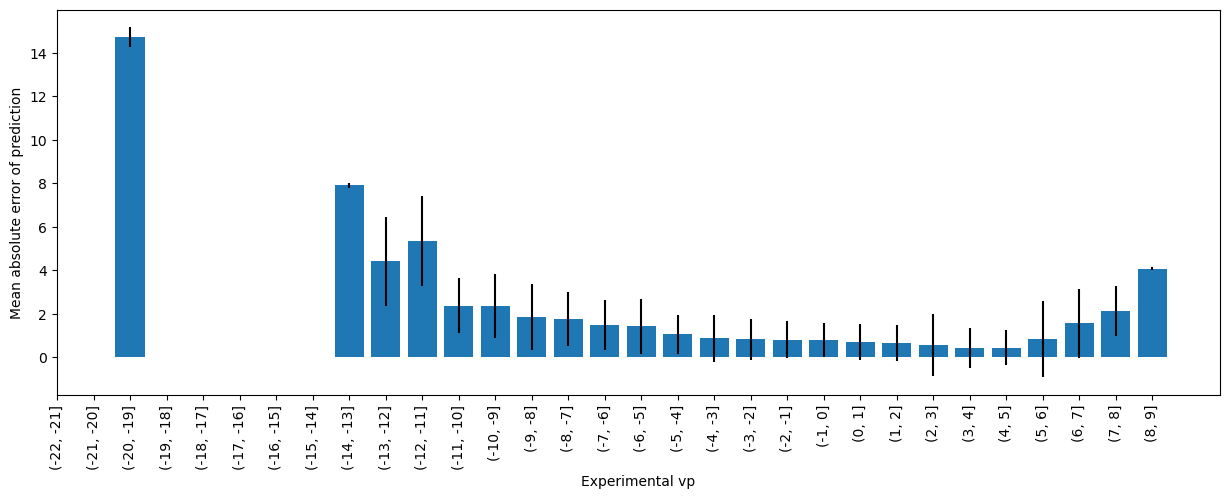

In [51]:
#and bin-wise: for each bin of 1 log unit, plot the mean absolute error
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
vp_bins = np.arange(-22, 10, 1)
vp_bins = [round(vp_bin, 1) for vp_bin in vp_bins]
vp_bins = np.array(vp_bins)
df_preds_many_to_many['vp_bins'] = pd.cut(df_preds_many_to_many['vp'], vp_bins)

#plot bins against mean absolute error
df_temp = df_preds_many_to_many.groupby('vp_bins').agg({'abs_error': ['mean', 'std']})
df_temp = df_temp.reset_index()
df_temp['vp_bins'] = df_temp['vp_bins'].astype(str)

axs.errorbar(df_temp['vp_bins'], df_temp['abs_error']['mean'], yerr=df_temp['abs_error']['std'], fmt='o')
axs.set_xlabel('Experimental vp')
axs.set_ylabel('Mean absolute error')
#set xticks
axs.set_xticks(df_temp['vp_bins'].tolist(), labels = df_temp['vp_bins'].tolist(),rotation=90)  
plt.show()
#barplot better?
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1, figsize=(15, 5))
vp_bins = np.arange(-22, 10, 1)
vp_bins = [round(vp_bin, 1) for vp_bin in vp_bins]
vp_bins = np.array(vp_bins)
df_preds_many_to_many['vp_bins'] = pd.cut(df_preds_many_to_many['vp'], vp_bins)

#plot bins against mean absolute error
df_temp = df_preds_many_to_many.groupby('vp_bins').agg({'abs_error': ['mean', 'std']})
df_temp = df_temp.reset_index()
df_temp['vp_bins'] = df_temp['vp_bins'].astype(str)

axs.bar(df_temp['vp_bins'], df_temp['abs_error']['mean'], yerr=df_temp['abs_error']['std'])
axs.set_xlabel('Experimental vp')
axs.set_ylabel('Mean absolute error of prediction')
#set xticks
axs.set_xticks(df_temp['vp_bins'].tolist(), labels = df_temp['vp_bins'].tolist(),rotation=90)
plt.show()
